# SLT-CE-2: Histogram Clustering

In this coding exercise, you will segment an image with histogram clustering (HC). You will implement two different methods: maximum a posterior probability (MAP) and deterministic annealing (DA) for predicting the cluster membership for each pixel.

<h2 style="background-color:#f0b375;"> References </h2>

[1] Histogram clustering for unsupervised image segmentation: http://ieeexplore.ieee.org/document/784981 (If you cannot access, you can try the same link after configuring your ETH VPN.)

[2] Lecture Slides 5: https://ml2.inf.ethz.ch/courses/slt/lectures/slt23_lecture05.pdf 

[3] Lecture script: https://ml2.inf.ethz.ch/courses/slt/lectures/SLT_Script.pdf, chapter 2.7

<h2 style="background-color:#f0b375;"> Setup </h2>

In [1]:
import sklearn as skl
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42) 

from sklearn.utils.validation import check_is_fitted
from matplotlib.image import imread
from sklearn.feature_extraction import image


## Texture and corresponding label map
(This texture is used to fit your model.)

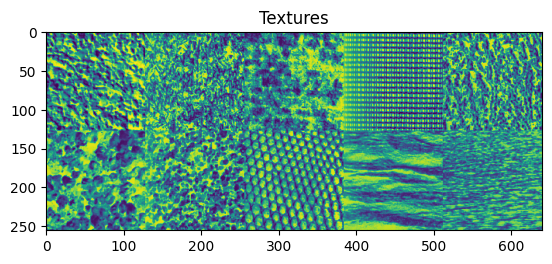

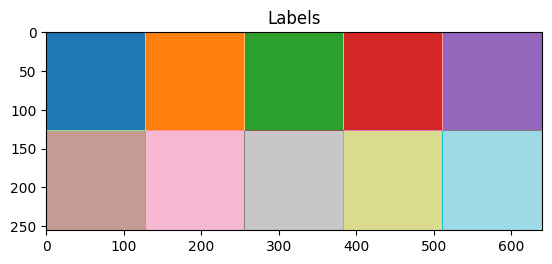

In [2]:
texture = imread("texture.png")

patch_grid_shape = (2, 5)
patch_shape = (128, 128)
label_map = np.ones(texture.shape)
for patch in range(np.prod(patch_grid_shape)):
    i, j = np.unravel_index(patch, patch_grid_shape)
    label_map[patch_shape[0] * i:patch_shape[0] * (i + 1), \
              patch_shape[1] * j:patch_shape[1] * (j + 1)] = np.ravel_multi_index((i, j), patch_grid_shape)
    

    

plt.imshow(texture)
plt.title("Textures")
plt.figure()
plt.imshow(label_map, cmap="tab20")
plt.title("Labels")
plt.show()

## Permuted texture and label map
(The permuted texture is used for the prediction)

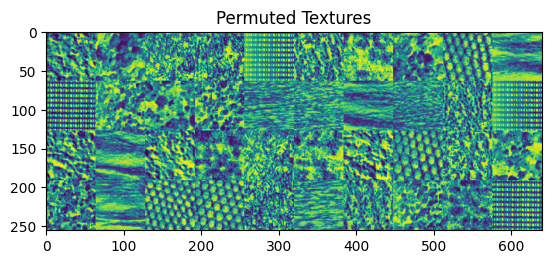

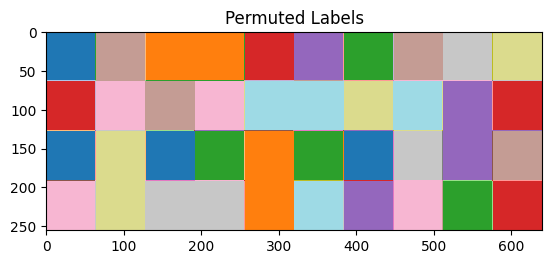

In [3]:
perm_patch_grid_shape = tuple(i * 2 for i in patch_grid_shape)
perm_patch_shape = tuple(i // 2 for i in patch_shape)
n_perm_patches = np.prod(patch_grid_shape) * 4

np.random.seed(5)
perm = np.random.permutation(n_perm_patches)

perm_texture = np.ones(texture.shape)
perm_label_map = np.ones(texture.shape)

for patch, perm_patch in enumerate(perm):
    i, j = np.unravel_index(patch, perm_patch_grid_shape) * np.array(perm_patch_shape)
    ip, jp = np.unravel_index(perm_patch, perm_patch_grid_shape) * np.array(perm_patch_shape)

    perm_texture[ip:ip + perm_patch_shape[0], jp:jp + perm_patch_shape[1]] \
        = texture[i:i + perm_patch_shape[0], j:j + perm_patch_shape[1]]

    perm_label_map[ip:ip + perm_patch_shape[0], jp:jp + perm_patch_shape[1]] \
        = label_map[i:i + perm_patch_shape[0], j:j + perm_patch_shape[1]]

plt.imshow(perm_texture)
plt.title("Permuted Textures")
plt.figure()
plt.imshow(perm_label_map, cmap="tab20")
plt.title("Permuted Labels")
plt.show()

<h2 style="background-color:#f0b375;">
Section 4.0 
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>

<p style="background-color:#adebad;">
    Read the references and recapitulate the parameter estimation formulas for both: maximum a posteriori probability estimation (MAP) and Deterministic Annealing (DA) estimation. In particular, write down how equation (5) in reference <a href=http://ieeexplore.ieee.org/document/784981>[1]</a> looks for the case of DA (using the notation of reference [1]).<br>
Hint: try to derive $\hat P(y|c)$ from $\hat P(c|x)$ and use the maximum entropy principle to find $\hat P(c|x)$.<br>
Hint 2: See <a href="https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed">markdown cheatsheet</a> for text editing.
</p>

Parameter estimation formula for MAP estimation:

\begin{align}
\hat P(x) &= \frac{n(x)}{\sum_{x'\in \textbf{X}}n(x')}, \nonumber \\
\hat P(y | c) &=  \sum_{x:\hat c(x) = c} \frac{n(x)}{\sum_{x' : c(x') = c} n(x') }\hat P(y|x), \tag{5}\\
\hat c(x) &= \argmin_a \left\{-\sum_{y \in \textbf Y} \hat P(y|x)\log \hat P(y|a) -\log P(\hat c^x_a) \right\}, \nonumber
\end{align}
where $n(x)$ denotes the number of times an object $x$ has been observed and
$$
\hat c^x_a(x') := \begin{cases} a, &\text{ if } x' = x, \\ \hat c(x'), &\text{ otherwise.}\end{cases}
$$

In the case of DA, equation (5) becomes $\hat{P}(y|c)= \frac{\sum_{x \in \textbf{X}} \hat{P}(c|x) \hat{P}(y|x)}{\sum_{x \in \textbf{X}} \hat{P}(a|x)}$, where $ \hat{P}(c|x) = \frac{\exp\left(-D_{KL}(\hat{P}(\cdot | x) || \hat{P}(\cdot | c))/T\right)}{\sum_{a \leq k}\exp\left(-D_{KL}(\hat{P}(\cdot | x) || \hat{P}(\cdot | a)/T)\right)}$, and $D_{KL}(\cdot || \cdot)$ denotes the Kullback-Leibler divergence.

In [83]:
class HistogramClustering(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for HistogramClustering (HC)
    
    Attributes:
        centroids (np.ndarray): Array of centroid distributions p(y|c) with shape (n_clusters, n_bins).
        
    Parameters:
        n_clusters (int): Number of clusters (textures).
        n_bins (int): Number of bins used to discretize the range of pixel values found in input image X.
        window_size (int): Size of the window used to compute the local histograms for each pixel.
                           Should be an odd number larger or equal to 3.
        random_state (int): Random seed.
        estimation (str): Whether to use Maximum a Posteriori ("MAP") or
                          Deterministic Annealing ("DA") estimation.
    """
    
    def __init__(self, n_clusters=10, n_bins=100, window_size=15, random_state=42, estimation="MAP", T=1, T0=0.2, tau=1e-4, eps=1e-4, xi=0.9):
        self.n_clusters = n_clusters
        self.n_bins = n_bins
        self.window_size = window_size
        self.random_state = random_state
        self.estimation = estimation
        self.T = T
        self.T0 = T0
        self.tau = tau
        self.eps = eps
        self.xi = xi
        # Add more parameters, if necessary.
    
    def make_img_patches(self, X):

        
        # pad for pixel centering
        pad = int(np.floor(self.window_size/2))

        X_padded = np.pad(X, ((pad,  pad), (pad, pad)), constant_values=-1)
        
        # extract patches from sliding window
        patches = image.extract_patches_2d(X_padded, (self.window_size, self.window_size))
            
        return patches
    
    def DKL(self, p, q):
        pass
    
    
    def make_histogram(self, patch):

        hist, _ = np.histogram(patch[patch!=-1], bins=np.linspace(0,1,self.n_bins+1))
        return hist / np.sum(hist)
    
    def fit(self, X, plot=False):
        """Compute HC for input image X
        
        Compute centroids.        
        
        Args:
            X (np.ndarray): Input array with shape (height, width)
        
        Returns:
            self
        """
        
        np.random.seed(self.random_state)
        
        # Data
        patches = self.make_img_patches(X)           
        histograms = np.array([self.make_histogram(patch) for patch in patches])

        
        if self.estimation == "MAP":
            
            # Initialize
            self.centroids = np.random.rand(self.n_clusters, self.n_bins)
            self.centroids = np.array([centroid / np.sum(centroid) for centroid in self.centroids])
            c = np.argmin(-np.matmul(histograms, np.log(self.centroids.T)), axis=1)
                 
            error = 1
            while error > self.tau:
                
                # Update
                centroids = np.array([np.mean(histograms[c == a], axis=0) for a in range(self.n_clusters)])
                error = np.linalg.norm(centroids - self.centroids)

                self.centroids = centroids + 1e-9
                self.centroids = np.clip(self.centroids, 0, 1)
                self.centroids = np.array([centroid / np.sum(centroid) for centroid in self.centroids])
                c = np.argmin(-np.matmul(histograms, np.log(self.centroids.T)), axis=1)
                
        elif self.estimation == "DA":
            
            # Code for Deterministic Annealing estimation
            
            # Initialize
            self.centroids = np.array([np.mean(histograms, axis=0) for a in range(self.n_clusters)])
            P = np.random.rand(X.size, self.n_clusters)
            P = np.array([P_i / np.sum(P_i) for P_i in P])
            
            while self.T > self.T0:                
                
                # Add random pertubation
                for i in range(self.n_clusters):
                    for j in range(i+1, self.n_clusters):
                        if np.linalg.norm(self.centroids[i,:] - self.centroids[j,:]) < self.eps:
                            self.centroids[i,:] += np.random.normal(scale=1e-4, size=self.n_bins)
                            self.centroids[j,:] += np.random.normal(scale=1e-4, size=self.n_bins)
                            self.centroids[i,:] = np.clip(self.centroids[i,:], 0, 1)
                            self.centroids[j,:] = np.clip(self.centroids[j,:], 0, 1)
                            self.centroids[i,:] /= np.sum(self.centroids[i,:])
                            self.centroids[j,:] /= np.sum(self.centroids[j,:])

                            
                error = 1
                while error > self.tau:
                    
                    # Save old centroids
                    old_centroids = self.centroids.copy()
                    
                    # Update
                    DKL = (-np.matmul(histograms, np.log(self.centroids+1e-8).T).T + np.sum(histograms*np.log(histograms+1e-8), axis=1)).T
                    P = np.exp(-DKL/self.T)
                    P = np.array([P_i / np.sum(P_i) for P_i in P])

                    self.centroids = np.matmul(P.T, histograms)
                    self.centroids = np.array([centroid / np.sum(centroid) for centroid in self.centroids])                  
                    error = np.linalg.norm(self.centroids - old_centroids) 
                    
                    
                # plot progress
                if plot:
                    C = self.predict(perm_texture)
                    matched, _ = match_labels(perm_label_map, C)
                    
                    plt.subplot(1,2,1)
                    plt.imshow(matched, cmap="tab20")
                    plt.title(f"Predicted Labels, T={self.T:.3f}")
                    
                    plt.subplot(1,2,2)
                    plt.imshow(perm_label_map, cmap="tab20")
                    plt.title(f"True Labels")
                    plt.show()
                         
                self.T *= self.xi  
                
                      
        _, self.label_perm = match_labels(label_map, self.predict(texture))
        return self
        

    def predict(self, X):
        """Predict cluster assignments for each pixel in image X.
        
        Args:
            X (np.ndarray): Input array with shape (height, width)
            
        Returns:
            C (np.ndarray): Assignment map (height, width) 
        """
        
        check_is_fitted(self, ["centroids"])
        
        patches = self.make_img_patches(X)
        histograms = np.array([self.make_histogram(patch) for patch in patches])
        
        if self.estimation == "MAP":
            C = np.reshape(np.argmin(- np.matmul(histograms, np.log(self.centroids.T)), axis=1), X.shape)
            
        elif self.estimation == "DA":
            DKL = (-np.matmul(histograms, np.log(self.centroids+1e-8).T).T + np.sum(histograms*np.log(histograms+1e-8), axis=1)).T
            P = np.exp(-DKL/self.T)
            P = np.array([P_i / np.sum(P_i) for P_i in P])
            C = np.reshape(np.argmax(P, axis=1), texture.shape)
        
        return C


    
    def generate(self, C):
        """Generate a sample image X from a texture label map C.
        
        The entries of C are integers from the set {1,...,n_clusters}. They represent the texture labels
        of each pixel. Given the texture labels, a sample image X is generated by sampling
        the value of each pixel from the fitted p(y|c).
        
        Args:
            C (np.ndarray): Input array with shape (height, width)
            
        Returns:
            X (np.ndarray): Sample image (height, width)
        """
        
        check_is_fitted(self, ["centroids"])
        
        X = np.zeros(C.shape)
        ls = np.linspace(0, 1, self.n_bins+1)
        ls = [(ls[i]+ls[i+1])/2 for i in range(len(ls)-1)]
        for i in range(C.shape[0]):
             for j in range(C.shape[1]):
                centroid = self.centroids[np.where(self.label_perm==C[i, j])[0]][0]
                X[i, j] = np.random.choice(ls, p=centroid)
              
                
        return X

<p style="background-color:#adebad;">
Implement the "MAP" part of the <b>fit method</b> for the template class HistogramClustering, according to the contract outlined in its docstring. You can add more class methods if necessary. Create an instance of your HC class with n_clusters = 10 and fit the image texture. Record the execution time.
</p>

In [29]:
%%time
HC = HistogramClustering()
HC.fit(texture)
check_is_fitted(HC, ["centroids"])

CPU times: user 11.7 s, sys: 3.17 s, total: 14.9 s
Wall time: 8.38 s


<h2 style="background-color:#f0b375;">
Section 4.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.5 </span>
</h2>

<p style="background-color:#adebad;">
    <ul style="background-color:#adebad;">
        <li> Implement the <b>predict method</b> for the template class HC, according to the contract outlined in its docstring.
        </li>        
        <li>
            Use HC.predict to predict the texture labels of perm_texture. Plot the predicted label map.
        </li>
    </ul>
</p>

In [30]:
from scipy.optimize import linear_sum_assignment

def match_labels(label_map, pred_label_map):
    
    n_labels = len(np.unique(label_map))
    
    cost = np.zeros((n_labels, n_labels))
    for i in range(n_labels):
        for j in range(n_labels):
            mask1 = (pred_label_map == i)
            mask2 = (label_map == j)
            cost[i, j] = np.sum(mask1*mask2)
                        
    _, new = linear_sum_assignment(-cost)
    
    return np.array([[new[label] for label in row] for row in pred_label_map]), new
    
    

In [31]:
%%time
predicted_perm_label_map = HC.predict(perm_texture)


CPU times: user 7.31 s, sys: 253 ms, total: 7.56 s
Wall time: 7.44 s


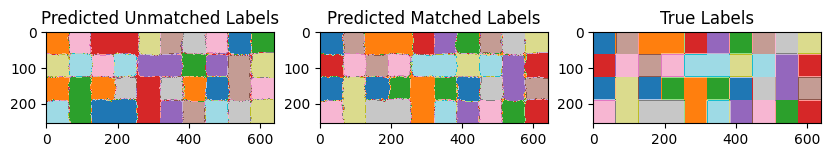

In [32]:
# Plot of predicted label map
plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.imshow(predicted_perm_label_map, cmap="tab20")
plt.title("Predicted Unmatched Labels")

matched, _ = match_labels(perm_label_map, predicted_perm_label_map)
plt.subplot(1,3,2)
plt.imshow(matched, cmap="tab20")
plt.title("Predicted Matched Labels")

plt.subplot(1,3,3)
plt.imshow(perm_label_map, cmap="tab20")
plt.title("True Labels")

plt.show()

<p style="background-color:#adebad;">
    Plot the confusion matrix for your predictions, using the perm_label_map. Make sure to permute the texture labels appropriately, to make them correspond to the true labels (see Hungarian algortihm to find the best match).
</p>

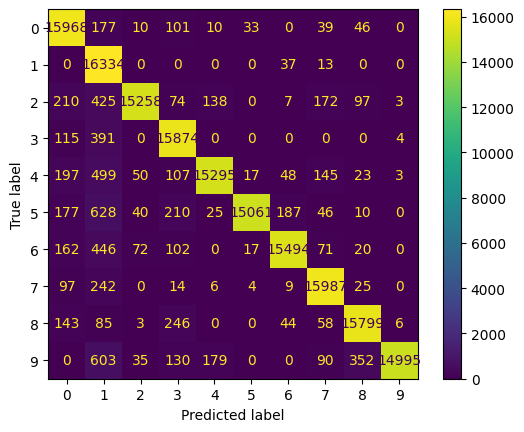

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

y_true = np.reshape(perm_label_map, (-1,))
y_pred = np.reshape(matched, (-1,))

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show() 


<p style="background-color:#adebad;">
    Using n_clusters=10, fit HC with all combinations of n_bins = 16, 32, 64 and window_size = 7, 9, 11.
    For each setting compute the accuracy of the prediction on perm_texture. Show the results in a 3x3 matrix and label the axes properly.
</p>

In [34]:
# 3x3 Matrix with accuracy scores of the different parameter combination

n_clusters = 10
n_bins_array = [16, 32, 64]
window_size_array = [7, 9, 11]
y_true = np.reshape(perm_label_map, (-1,))

accuracies = np.zeros((3,3))
label_maps = np.zeros((3,3, perm_label_map.shape[0], perm_label_map.shape[1]))
for i, n_bins in enumerate(n_bins_array):
    for j, window_size in enumerate(window_size_array):
        
        HC = HistogramClustering(n_clusters=n_clusters, n_bins=n_bins, window_size=window_size)
        HC.fit(texture)
        label_maps[i, j, : , :], _ = match_labels(perm_label_map, HC.predict(perm_texture))
        y_pred = np.reshape(label_maps[i, j], (-1,))
        accuracies[i, j] = accuracy_score(y_true, y_pred)

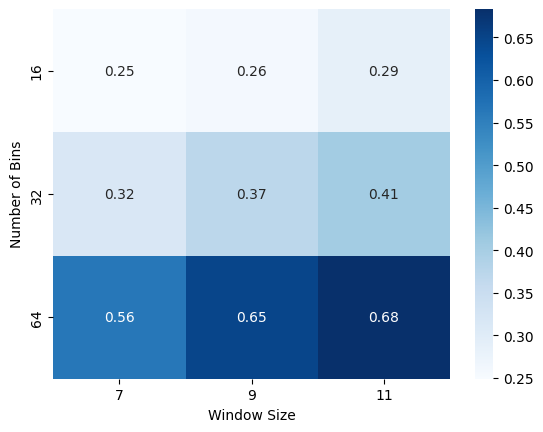

In [35]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame(accuracies, index=n_bins_array, columns=window_size_array)
ax = sns.heatmap(df, annot=True, cmap='Blues')
ax.set(xlabel="Window Size", ylabel="Number of Bins")
plt.show()

<p style="background-color:#adebad;">
    For each setting plot the prediction (i.e. the clustering) of the texture (perm_texture) itself. Arrange the plots next to each other in a grid and label them accordingly.
    </p>

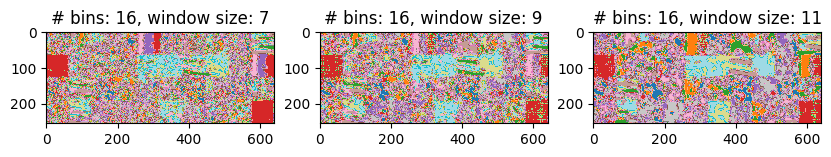

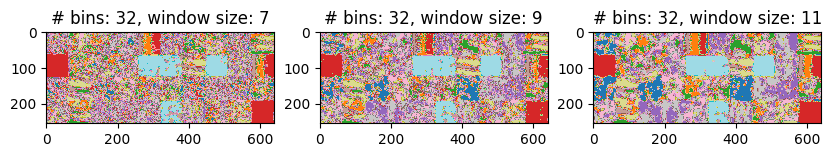

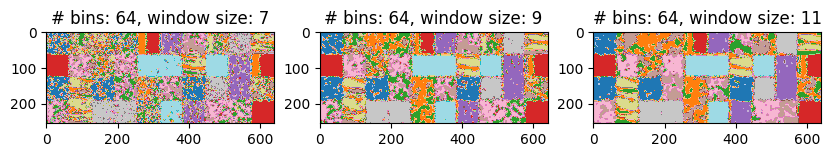

In [138]:
# Cluster predictions (9 plots arranged in a 3x3 grid)
for i, n_bins in enumerate(n_bins_array):
    plt.figure(figsize=(10,3))
    for j, window_size in enumerate(window_size_array):
        plt.subplot(1,3,j+1)
        plt.imshow(label_maps[i,j,:,:], cmap="tab20")
        plt.title(f"# bins: {n_bins}, window size: {window_size}")
    plt.show()

<h2 style="background-color:#f0b375;">
Section 5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5 </span>
</h2>

<ul style="background-color:#adebad;">
        <li> Implement the <b>generate</b> method for the template class HC, according to the contract outlined in its docstring.
        </li>
        <li>
        Use HC.generate to generate ten 128x128 patches, one for each texture. Plot the generated textures next to the ground truth textures.
        </li>
    </ul>

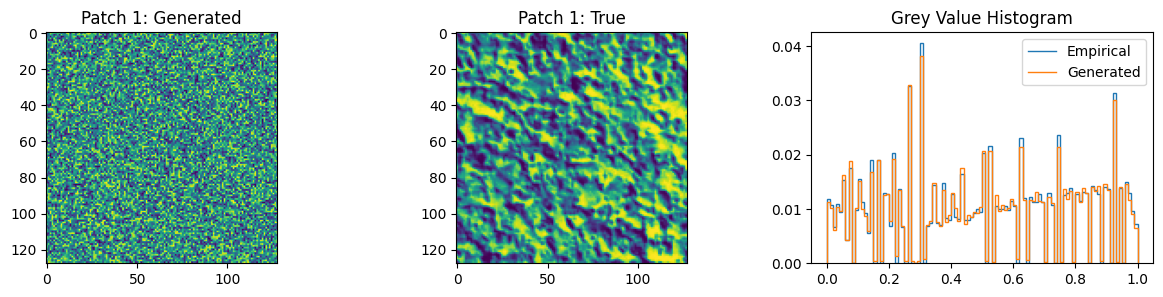

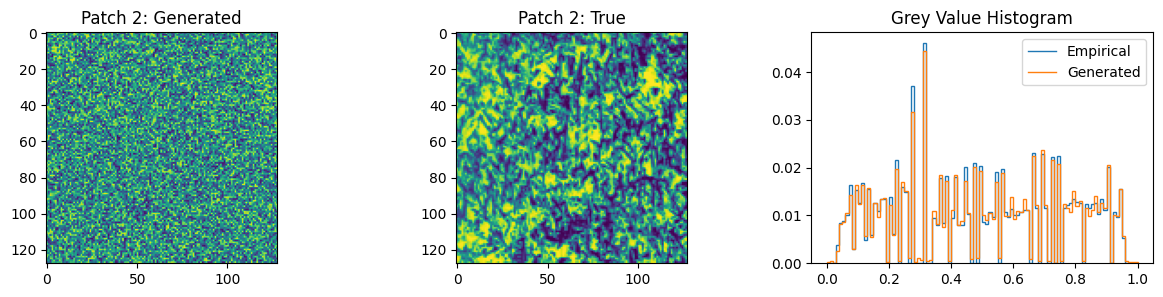

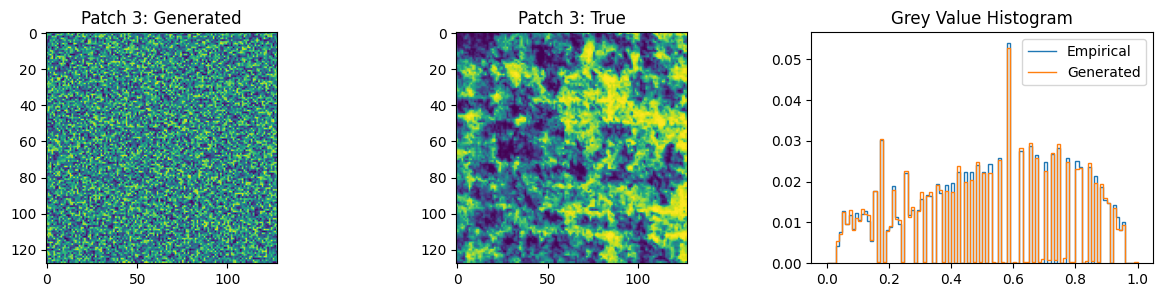

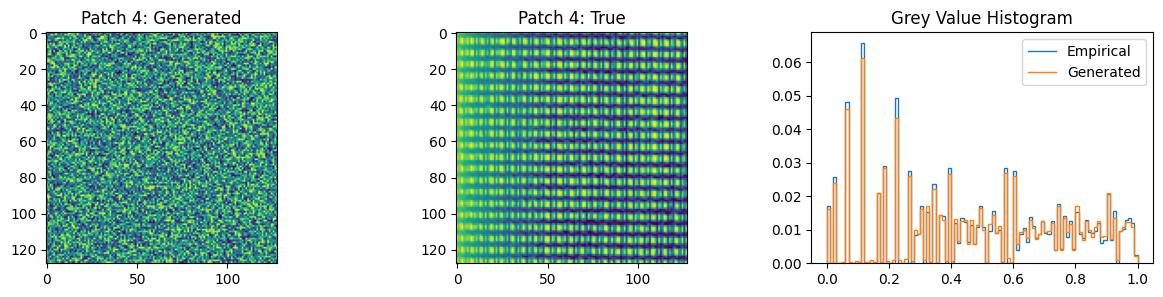

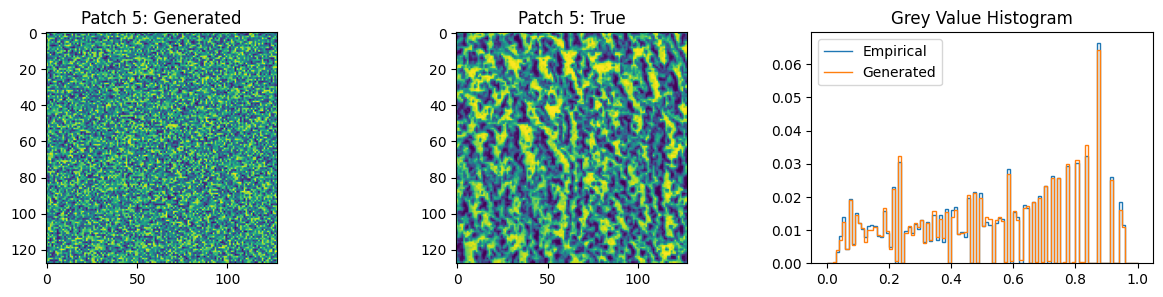

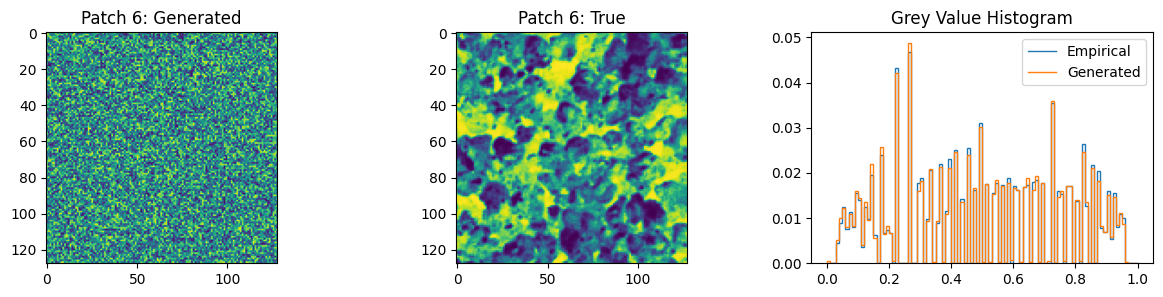

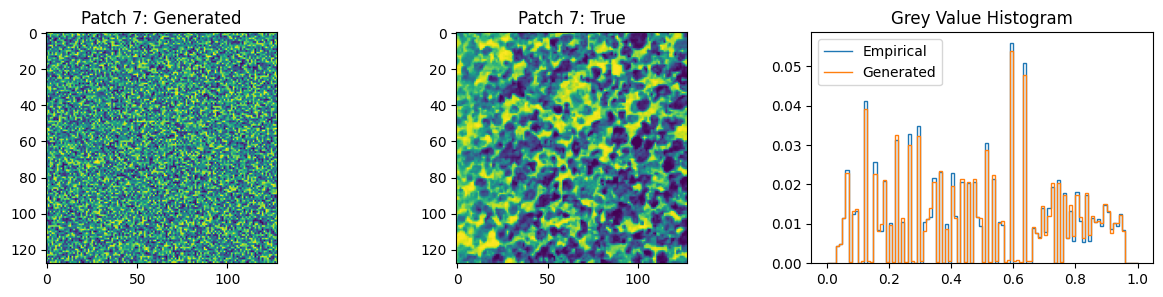

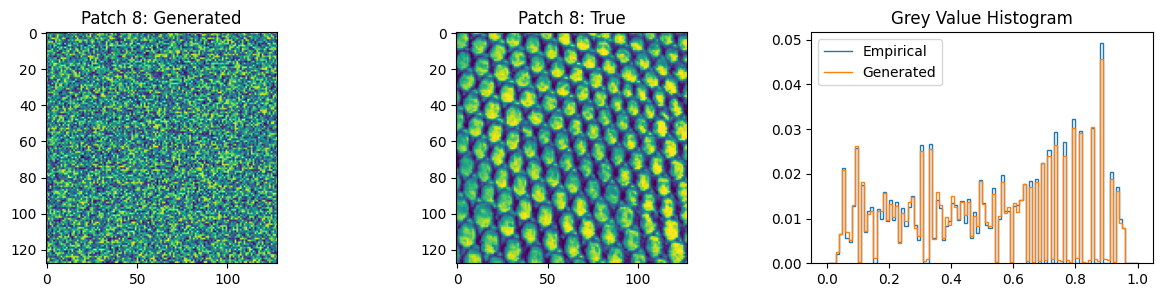

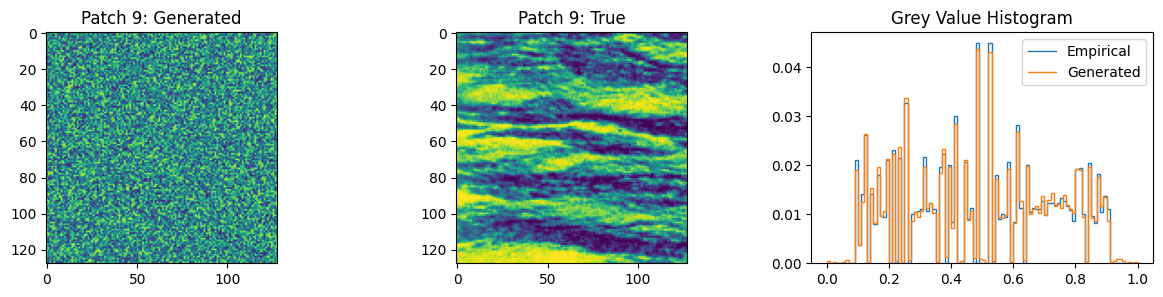

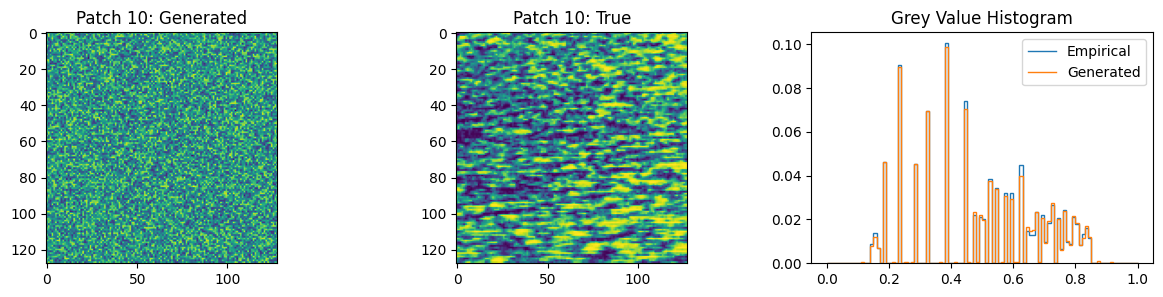

In [87]:
HC = HistogramClustering()
HC.fit(texture)

for patch in range(np.prod(patch_grid_shape)):
    i, j = np.unravel_index(patch, patch_grid_shape)
    truth = texture[patch_shape[0] * i:patch_shape[0] * (i + 1), patch_shape[1] * j:patch_shape[1] * (j + 1)] 
        
    C = np.ones(patch_shape, dtype=int) * patch
    generated = HC.generate(C)
    hist, _ = np.histogram(generated, bins=np.linspace(0,1,HC.n_bins+1))
    hist = hist / np.sum(hist)
    
    empirical, _ = np.histogram(truth, bins=np.linspace(0,1,HC.n_bins+1))
    empirical = empirical / np.sum(empirical)
    
    plt.figure(figsize=(15,3))
    plt.subplot(1,3,1)
    plt.imshow(generated)
    plt.title(f'Patch {patch+1}: Generated')    
    plt.subplot(1,3,2)
    plt.imshow(truth)
    plt.title(f'Patch {patch+1}: True')
    
    plt.subplot(1,3,3)
    plt.stairs(empirical, np.linspace(0,1,HC.n_bins+1))
    plt.stairs(hist, np.linspace(0,1,HC.n_bins+1))
    plt.legend(["Empirical", "Generated"])
    plt.title('Grey Value Histogram')
    
    plt.show()

<h2 style="background-color:#f0b375;">
Section 5.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.5 </span>
</h2>

<ul style="background-color:#adebad;">
    <li>
        Use k-means clustering to cluster the pixels of the texture (perm_texture). Set n_clusters=10, and use the local histogram vectors as features. Compare the predicted label map with k-means with the predicted label map obtained by HC.
    </li>
</ul>

In [19]:
# Predicted label map for k-means
# Predicted label map for HC
HC = HistogramClustering()
HC.fit(texture)
pred_label_map_HC, label_perm_HC = match_labels(perm_label_map, HC.predict(perm_texture))

In [20]:
from sklearn.cluster import KMeans

patches = HC.make_img_patches(texture)
X_train = np.array([HC.make_histogram(patch) for patch in patches])
     
patches = HC.make_img_patches(perm_texture)
X_test = np.array([HC.make_histogram(patch) for patch in patches])
        
KM = KMeans(n_clusters=10)
KM.fit(X_train)

pred_label_map_KM, label_perm_KM = match_labels(perm_label_map, np.reshape(KM.predict(X_test), perm_label_map.shape))


/Users/johanslettengren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


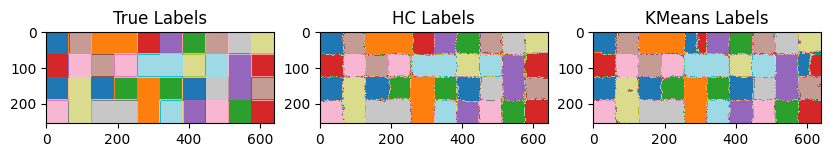

In [21]:
plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.imshow(perm_label_map, cmap="tab20")
plt.title("True Labels")

plt.subplot(1,3,2)
plt.imshow(pred_label_map_HC, cmap="tab20")
plt.title("HC Labels")

plt.subplot(1,3,3)
plt.imshow(pred_label_map_KM , cmap="tab20")
plt.title("KMeans Labels")
plt.show()

<ul style="background-color:#adebad;">
    <li>
        Plot and compare the confusion matrices for both, k-means, and HC.
    </li>
</ul>

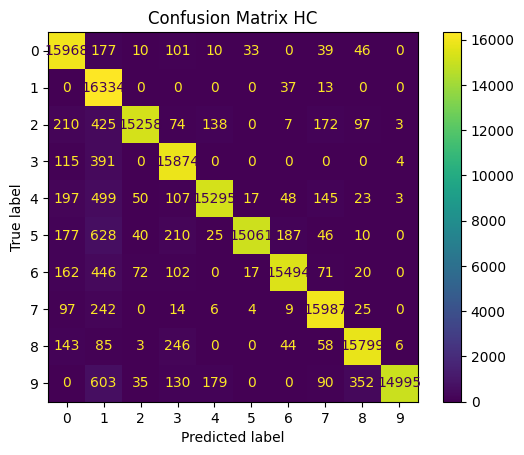

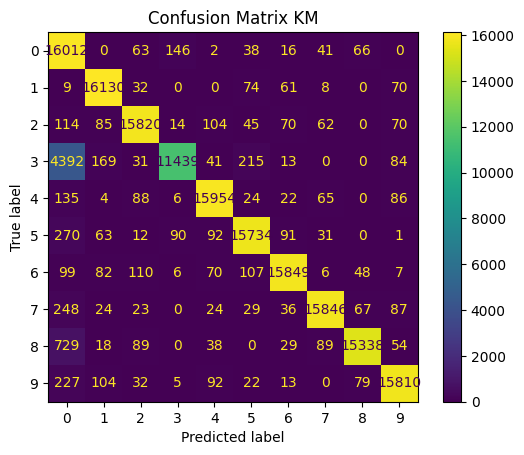

In [144]:
# Confusion matrices

y_true = np.reshape(perm_label_map, (-1,))

y_pred_HC = np.reshape(pred_label_map_HC, (-1,))
cm_HC = confusion_matrix(y_true, y_pred_HC)
ConfusionMatrixDisplay(confusion_matrix=cm_HC).plot()
plt.title("Confusion Matrix HC")


y_pred_KM = np.reshape(pred_label_map_KM, (-1,))
cm_KM = confusion_matrix(y_true, y_pred_KM)
ConfusionMatrixDisplay(confusion_matrix=cm_KM).plot()
plt.title("Confusion Matrix KM")

plt.show() 

<ul style="background-color:#adebad;">
        <li>
Plot the centroid histograms $\hat P(y|c)$ after fitting the texture image, one centroid histogram for every texture image. Compare them to the empirical histograms (i.e. show them both in one plot).
        </li>
    </ul>

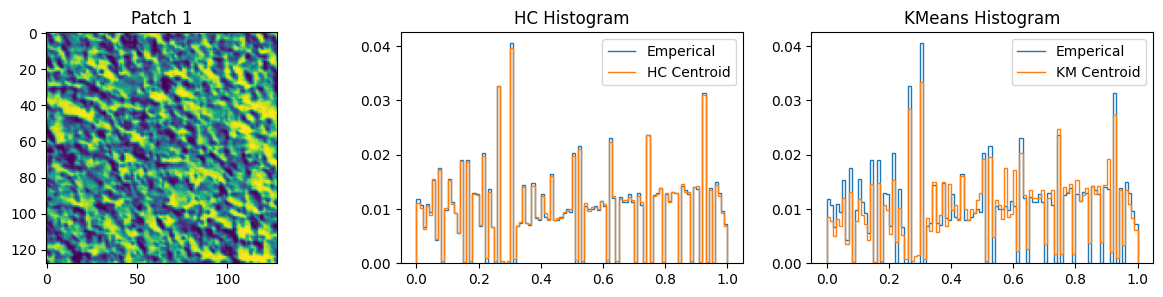

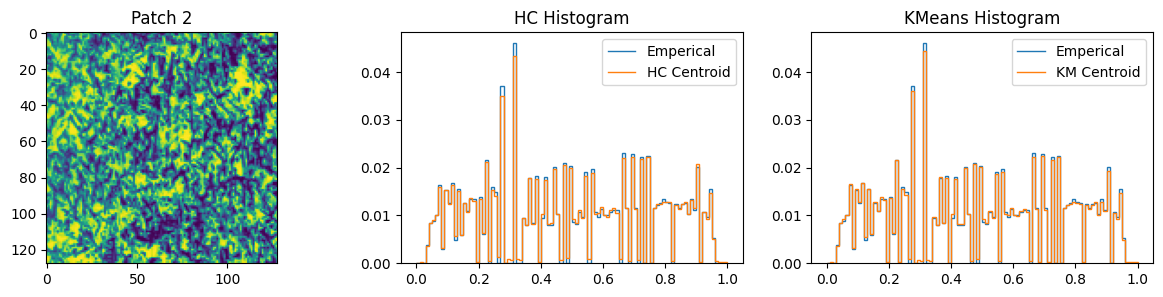

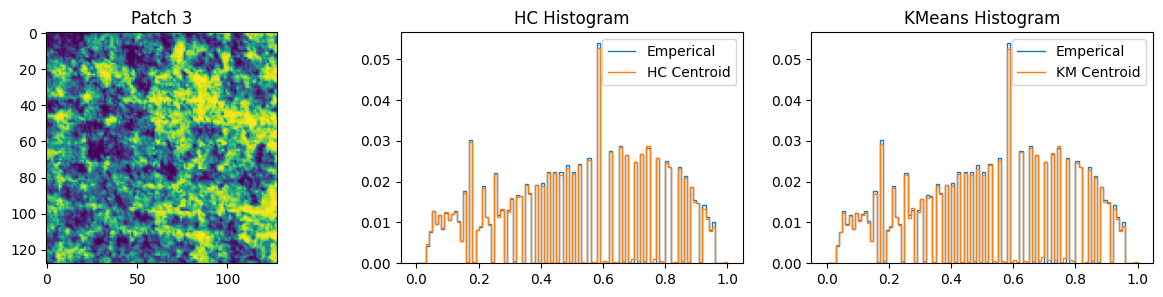

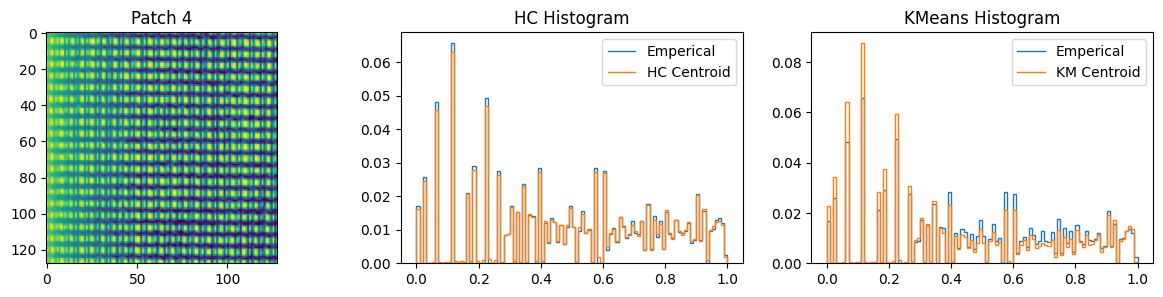

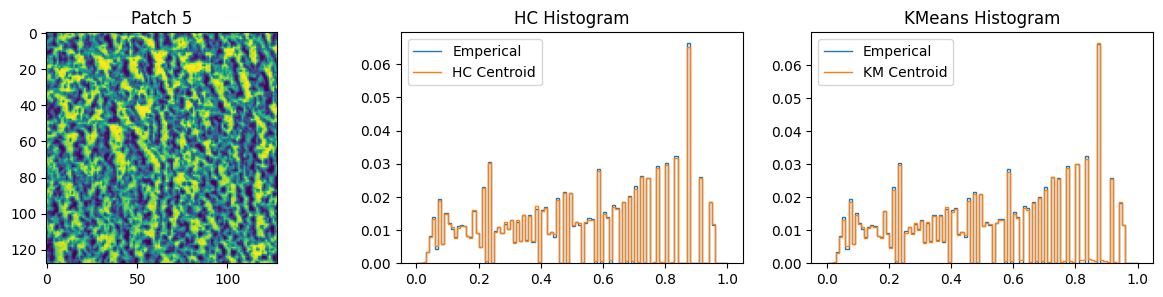

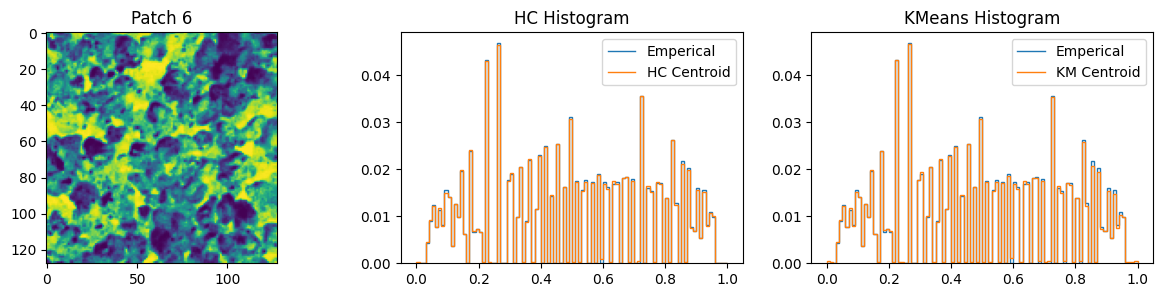

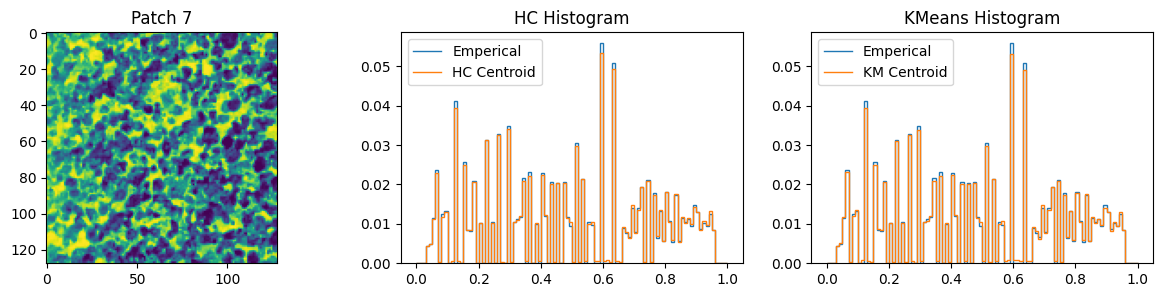

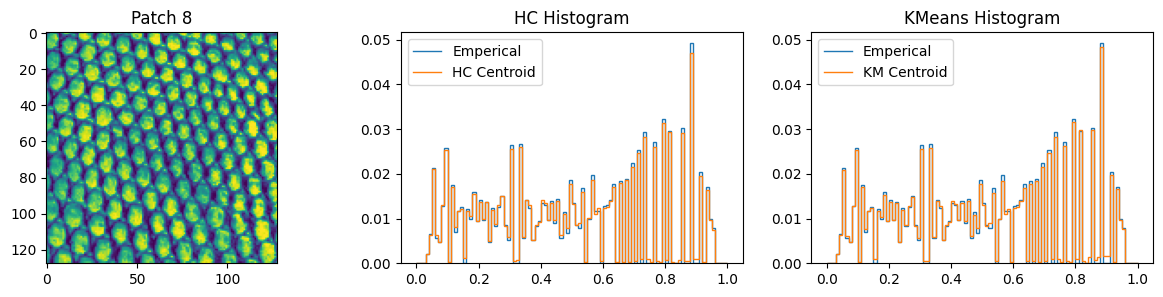

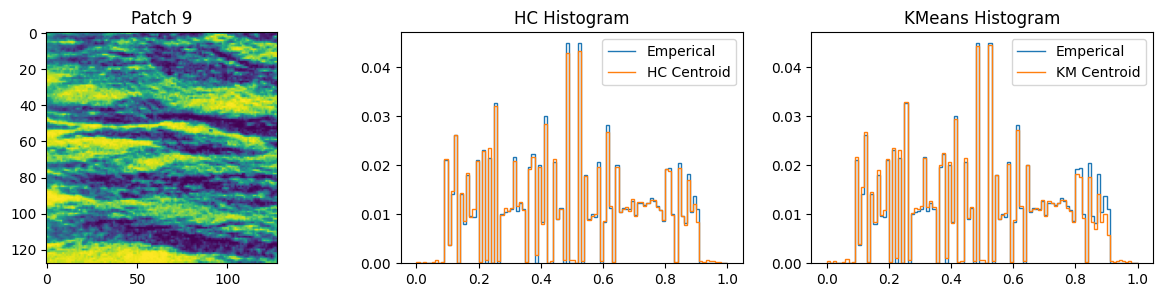

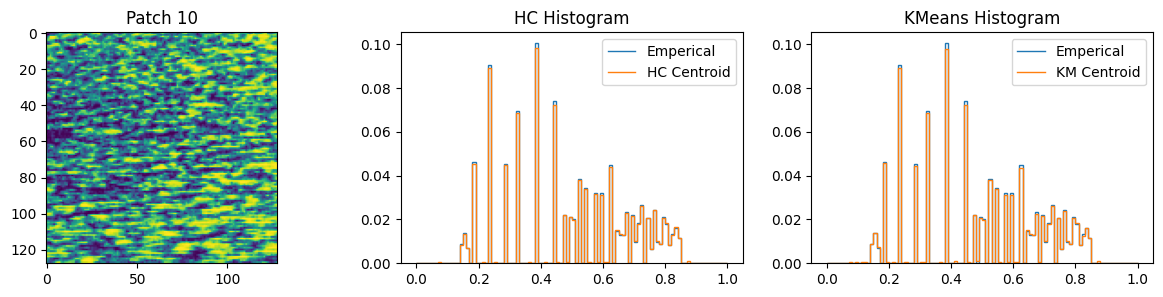

In [76]:
# Histograms
n_bins = HC.n_bins

for patch in range(np.prod(patch_grid_shape)):
    i, j = np.unravel_index(patch, patch_grid_shape)
    truth = texture[patch_shape[0] * i:patch_shape[0] * (i + 1), patch_shape[1] * j:patch_shape[1] * (j + 1)] 
    
    centroid_HC = HC.centroids[np.where(label_perm_HC==patch)[0]][0]
    centroid_KM = np.reshape(KM.cluster_centers_[np.where(label_perm_KM==patch)[0]], (-1,))
    empirical = HC.make_histogram(truth) 


    plt.figure(figsize=(15, 3))
    plt.subplot(1,3,1)

    plt.imshow(truth)
    plt.title(f'Patch {patch+1}')
    
    plt.subplot(1,3,2)
    plt.stairs(empirical, np.linspace(0,1,n_bins+1))
    plt.stairs(centroid_HC, np.linspace(0,1,n_bins+1))
    plt.legend(["Emperical", "HC Centroid"])
    plt.title('HC Histogram')
    
    plt.subplot(1,3,3)
    plt.stairs(empirical, np.linspace(0,1,n_bins+1))
    plt.stairs(centroid_KM, np.linspace(0,1,n_bins+1))
    plt.legend(["Emperical", "KM Centroid"])
    plt.title('KMeans Histogram')

    
    plt.show()

<h2 style="background-color:#f0b375;">
Section 6.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 6.0 </span>
</h2>

<ul style="background-color:#adebad;">
        <li>
        Implement the "DA" part of HC.fit.
        </li>
    </ul>

In [149]:
%%time
HC = HistogramClustering(estimation="DA")
HC.fit(texture)
check_is_fitted(HC, ["centroids"])

CPU times: user 1min 52s, sys: 1min 34s, total: 3min 27s
Wall time: 1min 5s


<ul style="background-color:#adebad;">
        <li>
        Plot the clustering (predicted labels) of the texture (perm_texture) at different temperatures during the annealing schedule. Describe what you observe.
        </li>
    </ul>

The prediction gets better as the temperature decreases, and the algorithm hones in on a specific region in the solution space. The algorithm likewise seems to identify fewer clusters when the temperature is high, but is able to correctly identify ten clusters once the temperature is sufficiently low (around 0.172).

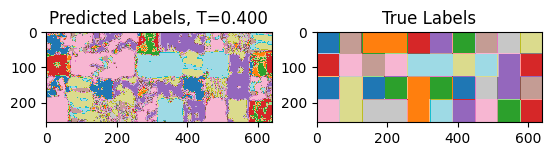

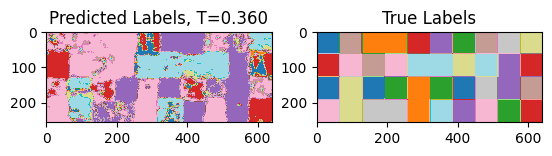

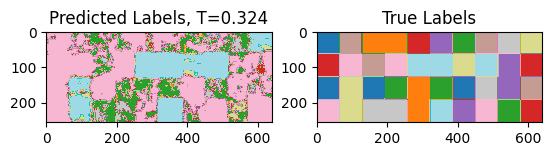

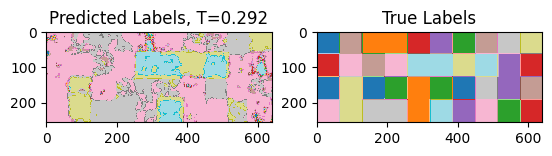

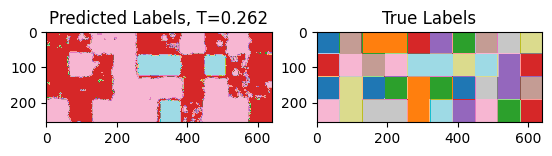

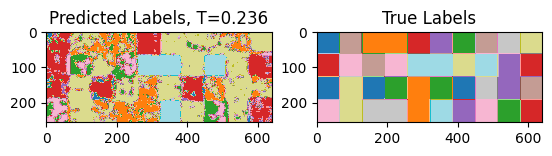

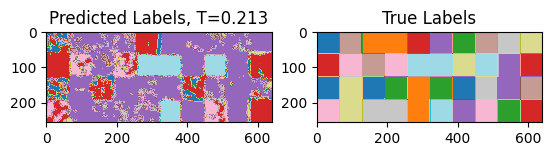

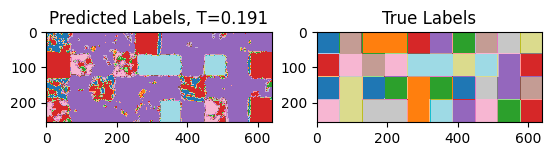

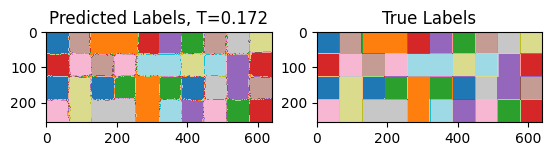

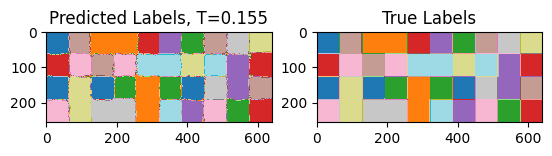

In [122]:
# Clustering at different temperatures
HC = HistogramClustering(estimation="DA", n_bins=128, window_size=15, T = 0.4, T0 = 0.15)
HC.fit(texture, plot=True)
check_is_fitted(HC, ["centroids"])

## Comments

We hope you found this exercise instructive.

Feel free to leave comments below, we will read them carefully.